# Libraries

In [1]:
library(ggplot2)
library(stringr)
library(GenomicRanges)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(ChIPseeker)
library(reshape2)
library(DESeq2)

Lade nötiges Paket: stats4

Lade nötiges Paket: BiocGenerics


Attache Paket: ‘BiocGenerics’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    IQR, mad, sd, var, xtabs


Die folgenden Objekte sind maskiert von ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Lade nötiges Paket: S4Vectors


Attache Paket: ‘S4Vectors’


Die folgenden Objekte sind maskiert von ‘package:base’:

    I, expand.grid, unname


Lade nötiges Paket: IRanges

Lade nötiges Paket: GenomeInfoDb

Lade nötiges Paket: GenomicFeatures

Lade nötiges Paket: AnnotationDbi

Lade nötiges Paket: Biobase

Welcome to Bioconductor

    Vignettes contain 

# Options

In [2]:
options(stringsAsFactors = F)

# Variables

In [3]:
cell_lines <- c("Ly1"
               ,"Ly8")

# Read in data

In [4]:
# read in counts
counts <- lapply(cell_lines
               ,function(cell_line){
                       read.table(file = paste0("counts_raw_"
                                                ,cell_line
                                                ,".txt"
                       )
                       ,header = T
                       )
               })
names(counts) <- cell_lines
print(str(counts))

List of 2
 $ Ly1:'data.frame':	193349 obs. of  8 variables:
  ..$ Ly1_KO_E8  : int [1:193349] 6 10 2 17 12 14 1730 4423 15 197 ...
  ..$ Ly1_KO_G1  : int [1:193349] 9 3 0 10 27 11 2231 6225 15 420 ...
  ..$ Ly1_KO_H3  : int [1:193349] 0 8 2 14 26 4 2473 6634 25 209 ...
  ..$ Ly1_cas9_N1: int [1:193349] 4 7 1 20 1 6 958 2106 18 95 ...
  ..$ Ly1_cas9_N7: int [1:193349] 11 13 0 59 5 14 1892 3944 9 131 ...
  ..$ Ly1_cas9_N9: int [1:193349] 5 11 14 21 8 20 2006 5642 29 381 ...
  ..$ Ly1_het_F10: int [1:193349] 2 6 0 21 8 4 1544 4104 7 157 ...
  ..$ Ly1_het_F9 : int [1:193349] 6 10 2 8 22 18 1924 4807 16 214 ...
 $ Ly8:'data.frame':	193349 obs. of  7 variables:
  ..$ Ly8_KO_G6   : int [1:193349] 1 3 15 18 26 7 2033 1761 9 268 ...
  ..$ Ly8_cas9_N11: int [1:193349] 13 24 8 12 64 25 6077 5255 53 613 ...
  ..$ Ly8_cas9_N3 : int [1:193349] 10 6 9 14 26 11 3488 3022 20 325 ...
  ..$ Ly8_cas9_N6 : int [1:193349] 7 10 30 14 27 12 2534 2345 35 458 ...
  ..$ Ly8_het_A9  : int [1:193349] 5 0 2 8 34 3 

In [5]:
# read in anno_peaks
anno_peaks <- lapply(cell_lines
               ,function(cell_line){
                       read.table(file = paste0("anno_peaks_raw_"
                                                ,cell_line
                                                ,".txt"
                       )
                       ,header = T
                       )
               })
names(anno_peaks) <- cell_lines
print(str(anno_peaks))

List of 2
 $ Ly1:'data.frame':	193349 obs. of  9 variables:
  ..$ peakID              : chr [1:193349] "1_10359_10442" "1_16201_16298" "1_29286_29427" "1_181400_181555" ...
  ..$ Chr                 : chr [1:193349] "1" "1" "1" "1" ...
  ..$ Start               : int [1:193349] 10359 16201 29286 181400 267944 586098 629896 633956 775168 778527 ...
  ..$ End                 : int [1:193349] 10442 16298 29427 181555 268048 586236 629990 634088 775278 778982 ...
  ..$ mean_count          : num [1:193349] 5.38 8.5 2.62 21.25 13.62 ...
  ..$ threshold_mean_count: int [1:193349] 20 20 20 20 20 20 20 20 20 20 ...
  ..$ filter_mean_count   : logi [1:193349] FALSE FALSE FALSE TRUE FALSE FALSE ...
  ..$ threshold_count     : int [1:193349] 20 20 20 20 20 20 20 20 20 20 ...
  ..$ filter_count        : logi [1:193349] FALSE FALSE FALSE TRUE TRUE FALSE ...
 $ Ly8:'data.frame':	193349 obs. of  9 variables:
  ..$ peakID              : chr [1:193349] "1_10359_10442" "1_16201_16298" "1_29286_29427" "1_

In [6]:
# read in anno_samples
anno_samples <- lapply(cell_lines
               ,function(cell_line){
                       read.table(file = paste0("anno_samples_"
                                                ,cell_line
                                                ,".txt"
                       )
                       ,header = T
                       )
               })
names(anno_samples) <- cell_lines
print(str(anno_samples))

List of 2
 $ Ly1:'data.frame':	8 obs. of  29 variables:
  ..$ ID_renamed                   : chr [1:8] "Ly1_KO_E8_1" "Ly1_KO_G1_1" "Ly1_KO_H3_1" "Ly1_cas9_N1_1" ...
  ..$ ID_original                  : chr [1:8] "read1_CGTACTAG_CTCTCTAT_Ly1_KO_E8.fastq" "read1_GGACTCCT_CTCTCTAT_Ly1_KO_G1.fastq" "read1_TAGGCATG_CTCTCTAT_Ly1_KO_H3.fastq" "read1_TAAGGCGA_GCGTAAGA_Ly1_cas9_N1.fastq" ...
  ..$ read                         : int [1:8] 1 1 1 1 1 1 1 1
  ..$ index1                       : chr [1:8] "CGTACTAG" "GGACTCCT" "TAGGCATG" "TAAGGCGA" ...
  ..$ index2                       : chr [1:8] "CTCTCTAT" "CTCTCTAT" "CTCTCTAT" "GCGTAAGA" ...
  ..$ cell_line                    : chr [1:8] "Ly1" "Ly1" "Ly1" "Ly1" ...
  ..$ genotype                     : chr [1:8] "KO" "KO" "KO" "cas9" ...
  ..$ clone                        : chr [1:8] "E8" "G1" "H3" "N1" ...
  ..$ seq_run                      : int [1:8] 2 2 2 2 2 2 2 2
  ..$ sample_prep                  : int [1:8] 3 3 3 3 2 3 3 3
  ..$ sample    

# Preprocess data

In [7]:
# check correctness
if(!(all(colnames(counts[[1]]) == rownames(anno_samples[[1]])))) print("ERROR: samples are not ordered similarly in counts and anno_samples")
if(!(all(rownames(counts[[1]]) == rownames(anno_peaks[[1]])))) print("ERROR: peaks are not ordered similarly in counts and anno_peaks")

In [8]:
# add total raw paek counts to sample annotation
for(cell_line in cell_lines){
    anno_samples[[cell_line]]$total_counts_raw <- colSums(counts[[cell_line]])
}
print(str(anno_samples))

List of 2
 $ Ly1:'data.frame':	8 obs. of  29 variables:
  ..$ ID_renamed                   : chr [1:8] "Ly1_KO_E8_1" "Ly1_KO_G1_1" "Ly1_KO_H3_1" "Ly1_cas9_N1_1" ...
  ..$ ID_original                  : chr [1:8] "read1_CGTACTAG_CTCTCTAT_Ly1_KO_E8.fastq" "read1_GGACTCCT_CTCTCTAT_Ly1_KO_G1.fastq" "read1_TAGGCATG_CTCTCTAT_Ly1_KO_H3.fastq" "read1_TAAGGCGA_GCGTAAGA_Ly1_cas9_N1.fastq" ...
  ..$ read                         : int [1:8] 1 1 1 1 1 1 1 1
  ..$ index1                       : chr [1:8] "CGTACTAG" "GGACTCCT" "TAGGCATG" "TAAGGCGA" ...
  ..$ index2                       : chr [1:8] "CTCTCTAT" "CTCTCTAT" "CTCTCTAT" "GCGTAAGA" ...
  ..$ cell_line                    : chr [1:8] "Ly1" "Ly1" "Ly1" "Ly1" ...
  ..$ genotype                     : chr [1:8] "KO" "KO" "KO" "cas9" ...
  ..$ clone                        : chr [1:8] "E8" "G1" "H3" "N1" ...
  ..$ seq_run                      : int [1:8] 2 2 2 2 2 2 2 2
  ..$ sample_prep                  : int [1:8] 3 3 3 3 2 3 3 3
  ..$ sample    

# Filtering

## Filter by mean peak counts

### Statistics before filtering

In [9]:
count_threshold <- 20 #10 #50 #
print(paste("the threshold for a gene is greater"
           ,count_threshold
            ," mean counts"
           )
     )

[1] "the threshold for a gene is greater 20  mean counts"


[1] "Ly1"
[1] "before filtering we have 193349 genes"
[1] "after allpying the threshold we will have 116911 genes"
[1] "Ly8"


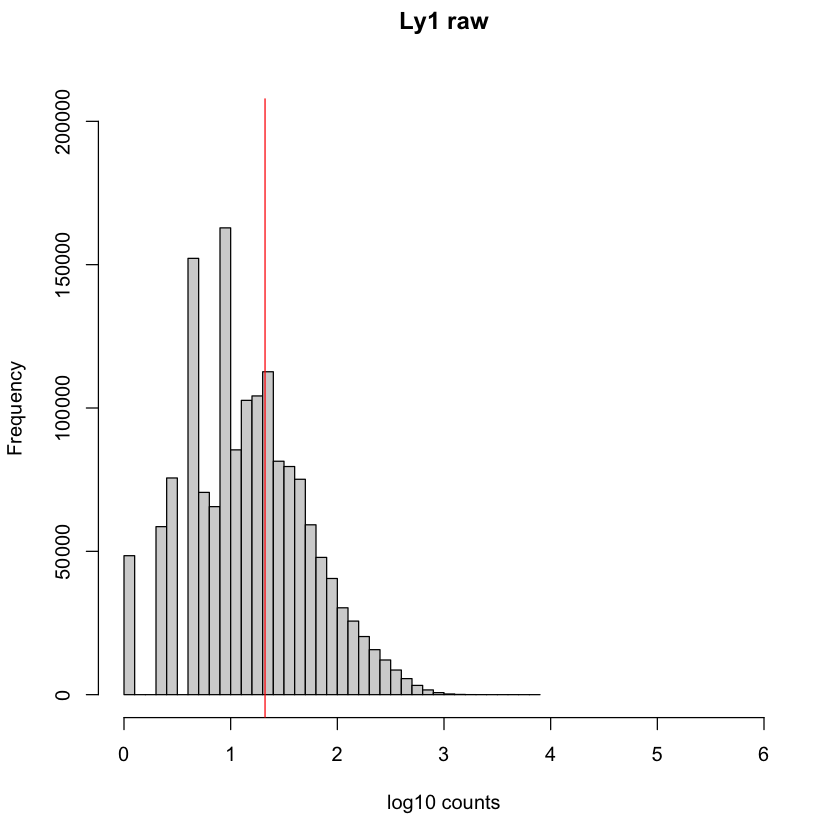

[1] "before filtering we have 193349 genes"
[1] "after allpying the threshold we will have 149340 genes"


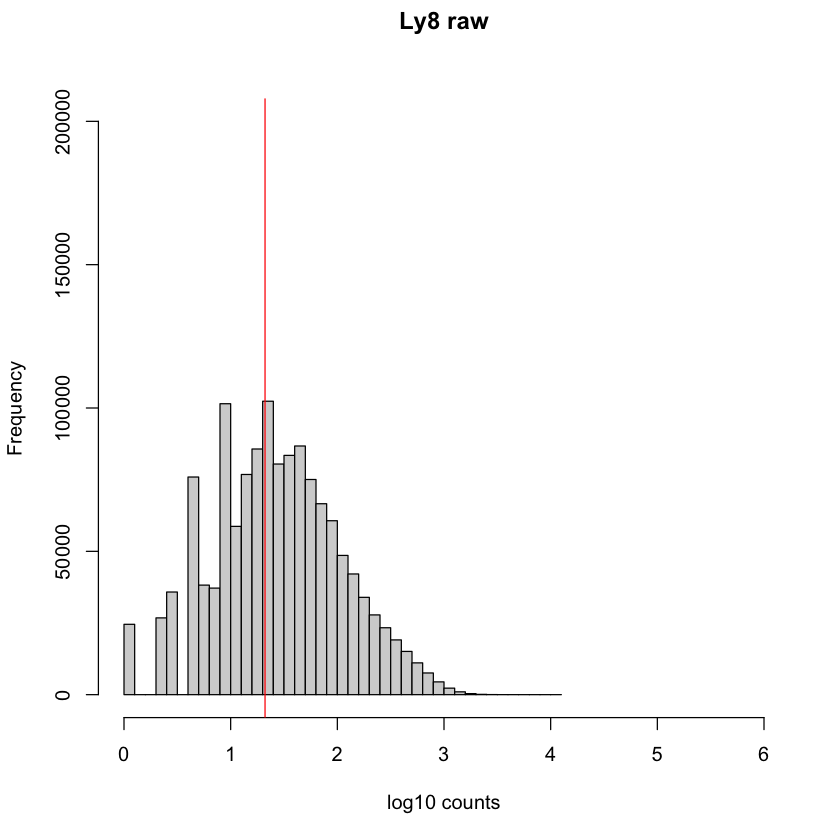

In [10]:
# make histogram of counts in all samples
for(cell_line in cell_lines
   ){
    print(cell_line)
    
    # subsample counts
    my_counts <- counts[[cell_line]]
    
    hist(log10(unlist(my_counts+1))
        ,breaks = 50
         ,main = paste(cell_line
                       ,"raw\n\n")
         ,ylab = "Frequency"
         ,xlab = "log10 counts"
         ,xlim = c(0,6)
         ,ylim = c(0,200000)
        )
    abline(v = log10(count_threshold +1)
         ,col = "red")
    
    print(paste("before filtering we have"
               ,nrow(my_counts)
               ,"genes"))
    
    
    print(paste("after allpying the threshold we will have"
              ,sum(rowSums(my_counts > count_threshold) != 0)
              ,"genes"))
}

[1] "Ly1"
   variable value
1 Ly1_KO_E8     6
2 Ly1_KO_E8    10
3 Ly1_KO_E8     2
4 Ly1_KO_E8    17
5 Ly1_KO_E8    12
6 Ly1_KO_E8    14
[1] "Ly8"
   variable value
1 Ly8_KO_G6     1
2 Ly8_KO_G6     3
3 Ly8_KO_G6    15
4 Ly8_KO_G6    18
5 Ly8_KO_G6    26
6 Ly8_KO_G6     7


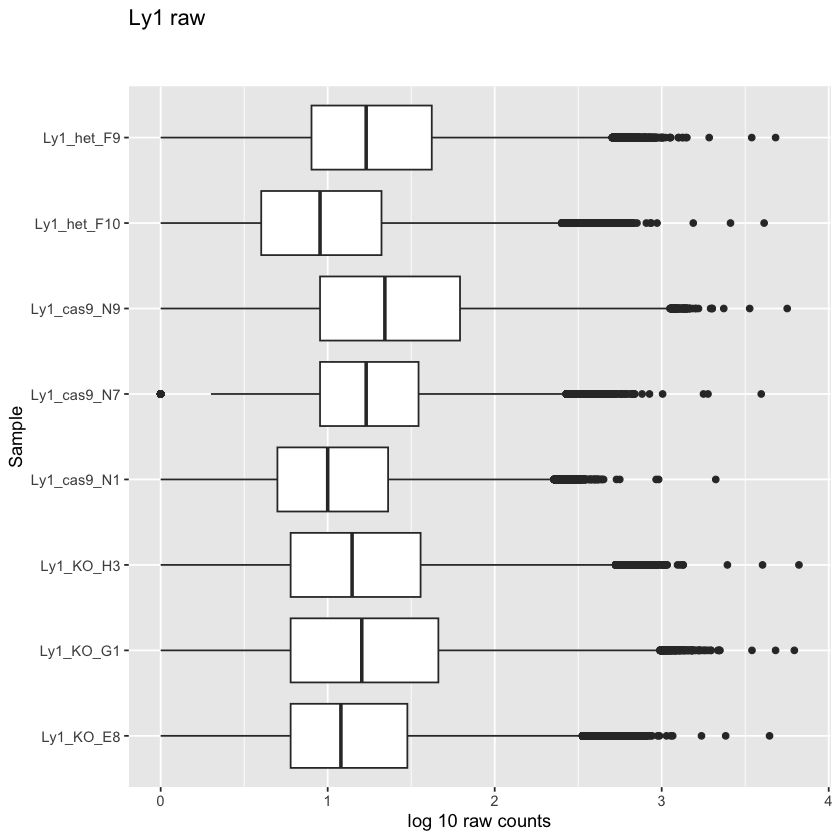

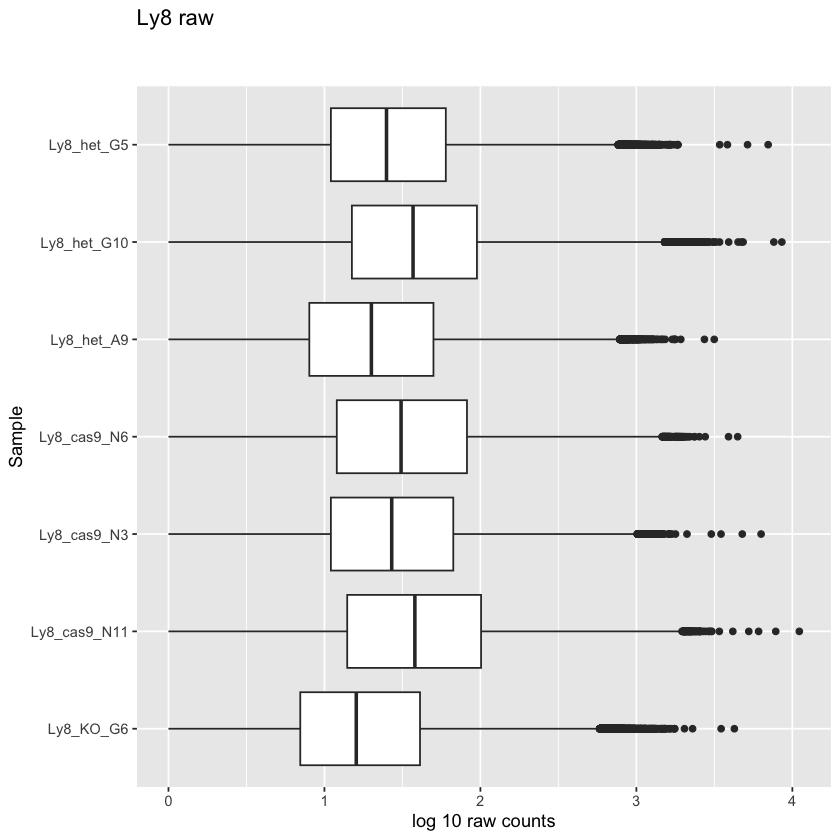

In [11]:
# bar plot of expression per sample
for(cell_line in cell_lines){
    print(cell_line)
    
    # subset counts
    my_counts <- counts[[cell_line]]
    
    # prepare df for plotting
    lf = melt(my_counts, id.vars=c())
    print(head(lf))

    # plot
    p <- ggplot(data=lf
           ,aes(x=variable
                ,y=log10(value+1)
               )
          ) + 
    geom_boxplot(aes(group=variable)) + 
    xlab("Sample") + 
    ylab("log 10 raw counts") + 
    ggtitle(paste(cell_line
                ,"raw\n\n")) +
      coord_flip()
    print(p)
}


### Filtering step

In [12]:
# write down info to anno_peaks
anno_peaks <- lapply(cell_lines
                    ,function(cell_line){
                        my_anno <- anno_peaks[[cell_line]]
                        my_counts <- counts[[cell_line]]
                        
                        idx_aboveThreshold <- rowSums(my_counts > count_threshold)!= 0
                        
                        my_anno$threshold_count <- count_threshold
                        my_anno$filter_count <- idx_aboveThreshold
                    
                        my_anno
                    })
names(anno_peaks) <- cell_lines
print(str(anno_peaks))

List of 2
 $ Ly1:'data.frame':	193349 obs. of  9 variables:
  ..$ peakID              : chr [1:193349] "1_10359_10442" "1_16201_16298" "1_29286_29427" "1_181400_181555" ...
  ..$ Chr                 : chr [1:193349] "1" "1" "1" "1" ...
  ..$ Start               : int [1:193349] 10359 16201 29286 181400 267944 586098 629896 633956 775168 778527 ...
  ..$ End                 : int [1:193349] 10442 16298 29427 181555 268048 586236 629990 634088 775278 778982 ...
  ..$ mean_count          : num [1:193349] 5.38 8.5 2.62 21.25 13.62 ...
  ..$ threshold_mean_count: int [1:193349] 20 20 20 20 20 20 20 20 20 20 ...
  ..$ filter_mean_count   : logi [1:193349] FALSE FALSE FALSE TRUE FALSE FALSE ...
  ..$ threshold_count     : num [1:193349] 20 20 20 20 20 20 20 20 20 20 ...
  ..$ filter_count        : logi [1:193349] FALSE FALSE FALSE TRUE TRUE FALSE ...
 $ Ly8:'data.frame':	193349 obs. of  9 variables:
  ..$ peakID              : chr [1:193349] "1_10359_10442" "1_16201_16298" "1_29286_29427" "1_

In [13]:
# filter counts by mean counts
counts_pf <- lapply(cell_lines
                   ,function(cell_line){
                        print(cell_line)

                        # subset coutns
                        my_counts <- counts[[cell_line]]
                       my_anno_peaks <- anno_peaks[[cell_line]]
                       
                       # filter counts
                        my_counts <- my_counts[my_anno_peaks$filter_count,]

                        my_counts
})
names(counts_pf) <- cell_lines
print(str(counts_pf))

[1] "Ly1"
[1] "Ly8"
List of 2
 $ Ly1:'data.frame':	116911 obs. of  8 variables:
  ..$ Ly1_KO_E8  : int [1:116911] 17 12 1730 4423 15 197 22 65 3 16 ...
  ..$ Ly1_KO_G1  : int [1:116911] 10 27 2231 6225 15 420 40 137 2 15 ...
  ..$ Ly1_KO_H3  : int [1:116911] 14 26 2473 6634 25 209 15 90 5 26 ...
  ..$ Ly1_cas9_N1: int [1:116911] 20 1 958 2106 18 95 7 41 3 14 ...
  ..$ Ly1_cas9_N7: int [1:116911] 59 5 1892 3944 9 131 18 65 9 41 ...
  ..$ Ly1_cas9_N9: int [1:116911] 21 8 2006 5642 29 381 34 176 28 57 ...
  ..$ Ly1_het_F10: int [1:116911] 21 8 1544 4104 7 157 11 59 1 7 ...
  ..$ Ly1_het_F9 : int [1:116911] 8 22 1924 4807 16 214 37 91 6 46 ...
 $ Ly8:'data.frame':	149340 obs. of  7 variables:
  ..$ Ly8_KO_G6   : int [1:149340] 3 15 26 7 2033 1761 9 268 39 5 ...
  ..$ Ly8_cas9_N11: int [1:149340] 24 8 64 25 6077 5255 53 613 72 24 ...
  ..$ Ly8_cas9_N3 : int [1:149340] 6 9 26 11 3488 3022 20 325 43 18 ...
  ..$ Ly8_cas9_N6 : int [1:149340] 10 30 27 12 2534 2345 35 458 60 28 ...
  ..$ Ly8_het

In [14]:
# filter anno_peaks by mean counts
anno_peaks_pf <- lapply(cell_lines
                   ,function(cell_line){
                        print(cell_line)

                        # subset coutns
                       my_anno_peaks <- anno_peaks[[cell_line]]
                       
                       # filter counts
                        my_anno_peaks <- my_anno_peaks[my_anno_peaks$filter_count,]

                        my_anno_peaks
})
names(anno_peaks_pf) <- cell_lines
print(str(anno_peaks_pf))

[1] "Ly1"
[1] "Ly8"
List of 2
 $ Ly1:'data.frame':	116911 obs. of  9 variables:
  ..$ peakID              : chr [1:116911] "1_181400_181555" "1_267944_268048" "1_629896_629990" "1_633956_634088" ...
  ..$ Chr                 : chr [1:116911] "1" "1" "1" "1" ...
  ..$ Start               : int [1:116911] 181400 267944 629896 633956 775168 778527 804858 827273 838474 865730 ...
  ..$ End                 : int [1:116911] 181555 268048 629990 634088 775278 778982 805040 827761 838582 865924 ...
  ..$ mean_count          : num [1:116911] 21.2 13.6 1844.8 4735.6 16.8 ...
  ..$ threshold_mean_count: int [1:116911] 20 20 20 20 20 20 20 20 20 20 ...
  ..$ filter_mean_count   : logi [1:116911] TRUE FALSE TRUE TRUE FALSE TRUE ...
  ..$ threshold_count     : num [1:116911] 20 20 20 20 20 20 20 20 20 20 ...
  ..$ filter_count        : logi [1:116911] TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ Ly8:'data.frame':	149340 obs. of  9 variables:
  ..$ peakID              : chr [1:149340] "1_16201_16298" "1_2928

In [15]:
# add total count after filtering to anno_samples
anno_samples <- lapply(cell_lines
                      ,function(cell_line){
                          my_anno_sample <- anno_samples[[cell_line]]
                          #print(str(my_anno_sample))
                          my_counts <- counts[[cell_line]]
                          my_counts_pf <- counts_pf[[cell_line]]
                          
                          my_anno_sample$nr_peaks_raw <- nrow(my_counts)
                          my_anno_sample$total_counts_raw_pf <- colSums(my_counts_pf)
                          my_anno_sample$nr_peaks_pf <- nrow(my_counts_pf)
                          
                          my_anno_sample
                      })
names(anno_samples) <- cell_lines
print(str(anno_samples))

List of 2
 $ Ly1:'data.frame':	8 obs. of  29 variables:
  ..$ ID_renamed                   : chr [1:8] "Ly1_KO_E8_1" "Ly1_KO_G1_1" "Ly1_KO_H3_1" "Ly1_cas9_N1_1" ...
  ..$ ID_original                  : chr [1:8] "read1_CGTACTAG_CTCTCTAT_Ly1_KO_E8.fastq" "read1_GGACTCCT_CTCTCTAT_Ly1_KO_G1.fastq" "read1_TAGGCATG_CTCTCTAT_Ly1_KO_H3.fastq" "read1_TAAGGCGA_GCGTAAGA_Ly1_cas9_N1.fastq" ...
  ..$ read                         : int [1:8] 1 1 1 1 1 1 1 1
  ..$ index1                       : chr [1:8] "CGTACTAG" "GGACTCCT" "TAGGCATG" "TAAGGCGA" ...
  ..$ index2                       : chr [1:8] "CTCTCTAT" "CTCTCTAT" "CTCTCTAT" "GCGTAAGA" ...
  ..$ cell_line                    : chr [1:8] "Ly1" "Ly1" "Ly1" "Ly1" ...
  ..$ genotype                     : chr [1:8] "KO" "KO" "KO" "cas9" ...
  ..$ clone                        : chr [1:8] "E8" "G1" "H3" "N1" ...
  ..$ seq_run                      : int [1:8] 2 2 2 2 2 2 2 2
  ..$ sample_prep                  : int [1:8] 3 3 3 3 2 3 3 3
  ..$ sample    

### Statistics after filtering

[1] "Ly1"
[1] "Ly8"


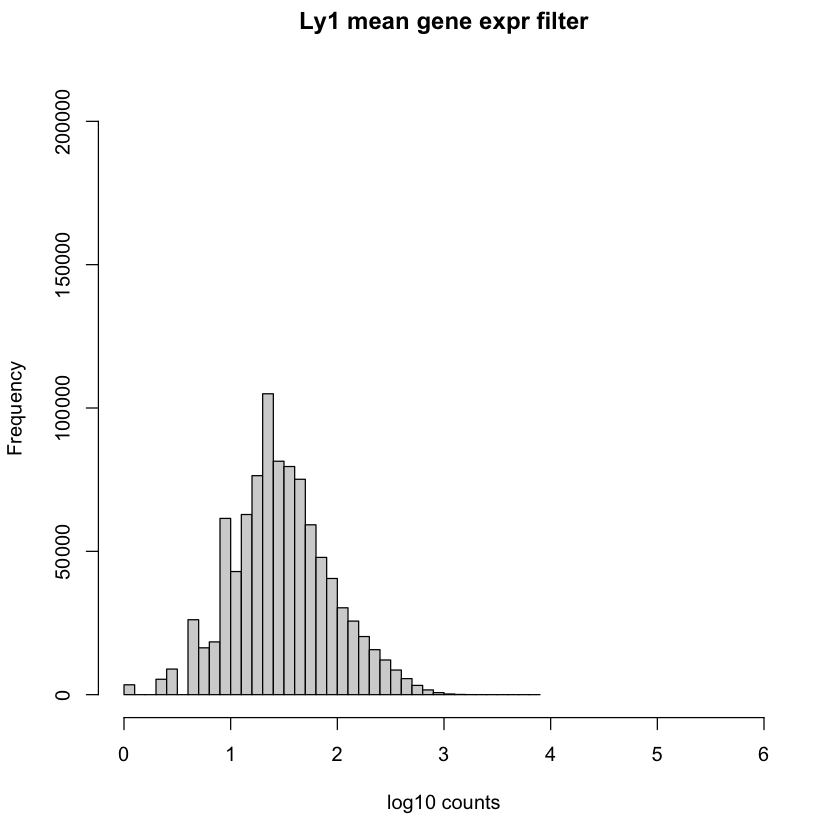

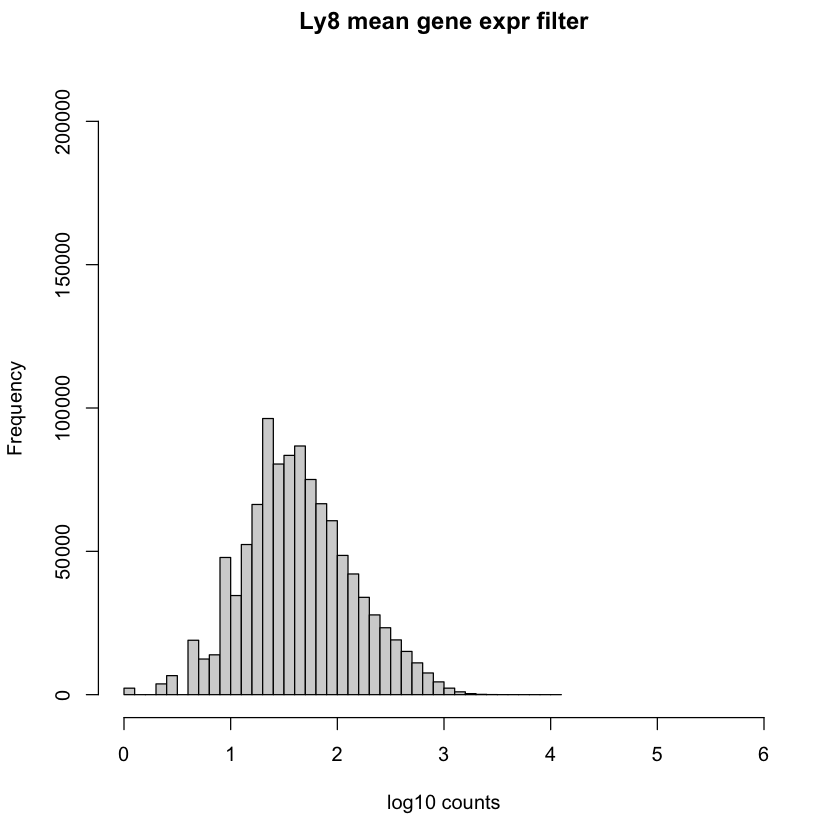

In [16]:
# make histogram of counts in all samples
for(cell_line in cell_lines){
    print(cell_line)
    
    # subsample counts
    my_counts <- counts_pf[[cell_line]]
    
    hist(log10(unlist(my_counts+1))
        ,breaks = 50
         ,main = paste(cell_line
                       ,"mean gene expr filter\n\n")
         ,ylab = "Frequency"
         ,xlab = "log10 counts"
         ,xlim = c(0,6)
         ,ylim = c(0,200000)
        )
}



[1] "Ly1"
   variable value
1 Ly1_KO_E8    17
2 Ly1_KO_E8    12
3 Ly1_KO_E8  1730
4 Ly1_KO_E8  4423
5 Ly1_KO_E8    15
6 Ly1_KO_E8   197
[1] "Ly8"
   variable value
1 Ly8_KO_G6     3
2 Ly8_KO_G6    15
3 Ly8_KO_G6    26
4 Ly8_KO_G6     7
5 Ly8_KO_G6  2033
6 Ly8_KO_G6  1761


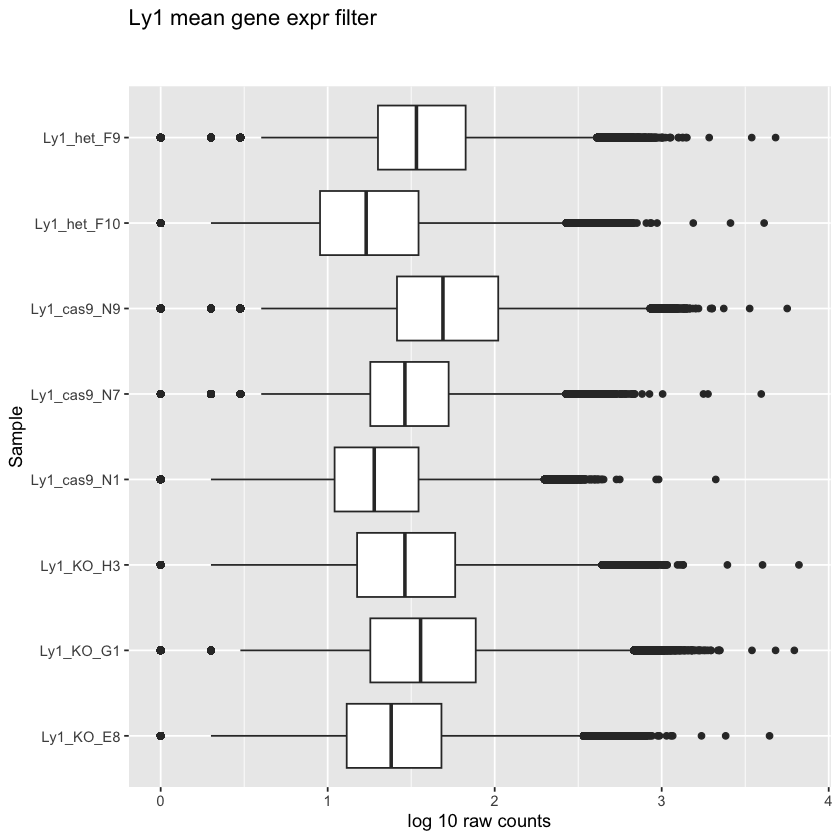

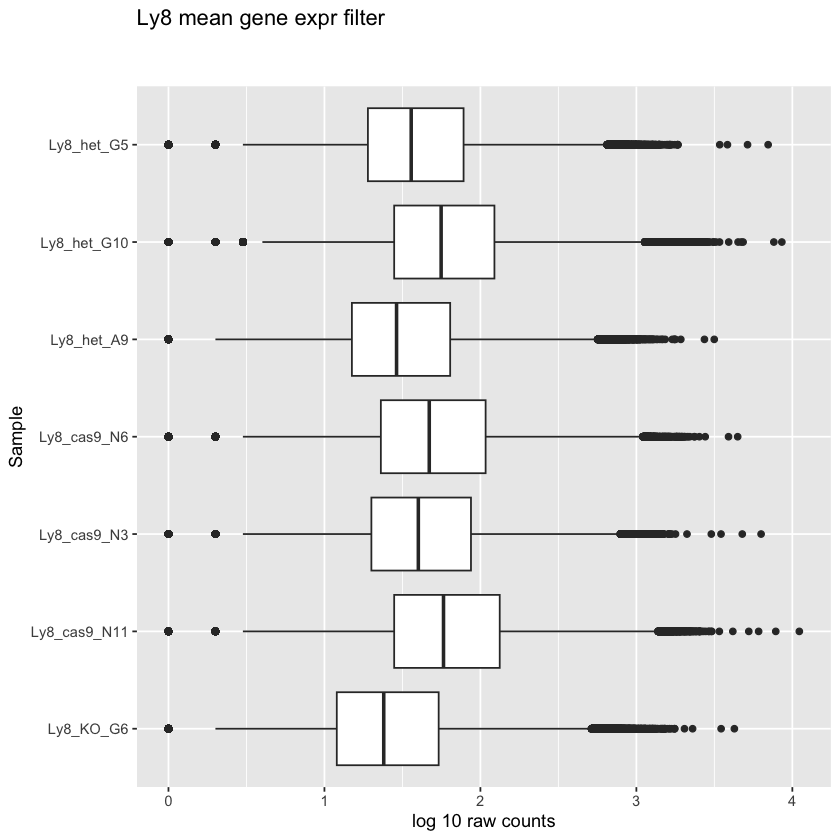

In [17]:
# bar plot of expression per sample
for(cell_line in cell_lines){
    print(cell_line)
    
    # subset counts
    my_counts <- counts_pf[[cell_line]]
    
    # prepare df for plotting
    lf = melt(my_counts, id.vars=c())
    print(head(lf))

    # plot
    p <- ggplot(data=lf
           ,aes(x=variable
                ,y=log10(value+1)
               )
          ) + 
    geom_boxplot(aes(group=variable)) + 
    xlab("Sample") + 
    ylab("log 10 raw counts") + 
    ggtitle(paste(cell_line
                       ,"mean gene expr filter\n\n")) +
      coord_flip()
    print(p)
}



# Peak annotation

In [18]:
print(str(anno_peaks_pf))

List of 2
 $ Ly1:'data.frame':	116911 obs. of  9 variables:
  ..$ peakID              : chr [1:116911] "1_181400_181555" "1_267944_268048" "1_629896_629990" "1_633956_634088" ...
  ..$ Chr                 : chr [1:116911] "1" "1" "1" "1" ...
  ..$ Start               : int [1:116911] 181400 267944 629896 633956 775168 778527 804858 827273 838474 865730 ...
  ..$ End                 : int [1:116911] 181555 268048 629990 634088 775278 778982 805040 827761 838582 865924 ...
  ..$ mean_count          : num [1:116911] 21.2 13.6 1844.8 4735.6 16.8 ...
  ..$ threshold_mean_count: int [1:116911] 20 20 20 20 20 20 20 20 20 20 ...
  ..$ filter_mean_count   : logi [1:116911] TRUE FALSE TRUE TRUE FALSE TRUE ...
  ..$ threshold_count     : num [1:116911] 20 20 20 20 20 20 20 20 20 20 ...
  ..$ filter_count        : logi [1:116911] TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ Ly8:'data.frame':	149340 obs. of  9 variables:
  ..$ peakID              : chr [1:149340] "1_16201_16298" "1_29286_29427" "1_267944_2

>> preparing features information...		 2023-08-22 17:38:55 
>> identifying nearest features...		 2023-08-22 17:39:07 
>> calculating distance from peak to TSS...	 2023-08-22 17:39:11 
>> assigning genomic annotation...		 2023-08-22 17:39:11 
>> adding gene annotation...			 2023-08-22 17:40:53 


Lade nötiges Paket: org.Hs.eg.db



'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-08-22 17:40:55 
>> done...					 2023-08-22 17:40:55 
$rect
$rect$w
[1] 0.9471

$rect$h
[1] 0.3888

$rect$left
[1] 0.02645

$rect$top
[1] 0.6944


$text
$text$x
 [1] 0.17225 0.17225 0.17225 0.17225 0.17225 0.17225 0.17225 0.17225 0.17225
[10] 0.17225 0.17225 0.17225 0.17225

$text$y
 [1] 0.6666286 0.6388571 0.6110857 0.5833143 0.5555429 0.5277714 0.5000000
 [8] 0.4722286 0.4444571 0.4166857 0.3889143 0.3611429 0.3333714


>> preparing features information...		 2023-08-22 17:40:56 
>> identifying nearest features...		 2023-08-22 17:40:56 
>> calculating distance from peak to TSS...	 2023-08-22 17:40:59 
>> assigning genomic annotation...		 2023-08-22 17:40:59 
>> adding gene annotation...			 2023-08-22 17:41:08 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-08-22 17:41:09 
>> done...					 2023-08-22 17:41:09 


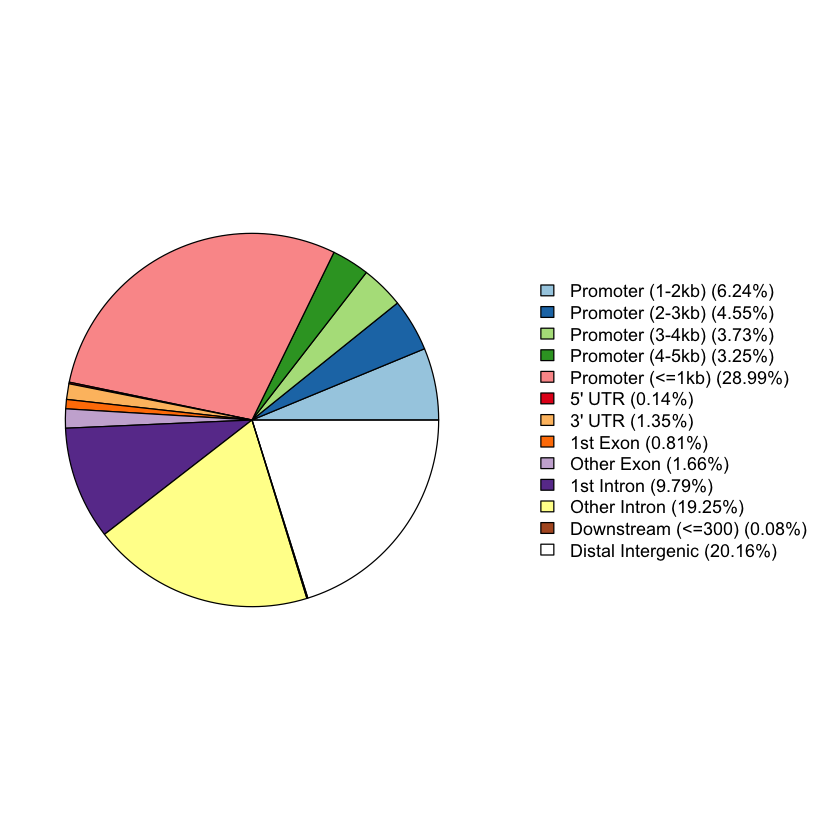

$rect
$rect$w
[1] 0.9471

$rect$h
[1] 0.3888

$rect$left
[1] 0.02645

$rect$top
[1] 0.6944


$text
$text$x
 [1] 0.17225 0.17225 0.17225 0.17225 0.17225 0.17225 0.17225 0.17225 0.17225
[10] 0.17225 0.17225 0.17225 0.17225

$text$y
 [1] 0.6666286 0.6388571 0.6110857 0.5833143 0.5555429 0.5277714 0.5000000
 [8] 0.4722286 0.4444571 0.4166857 0.3889143 0.3611429 0.3333714


List of 2
 $ Ly1:'data.frame':	116911 obs. of  34 variables:
  ..$ peakID              : chr [1:116911] "1_181400_181555" "1_267944_268048" "1_629896_629990" "1_633956_634088" ...
  ..$ Chr                 : chr [1:116911] "1" "1" "1" "1" ...
  ..$ Start               : int [1:116911] 181400 267944 629896 633956 775168 778527 804858 827273 838474 865730 ...
  ..$ End                 : int [1:116911] 181555 268048 629990 634088 775278 778982 805040 827761 838582 865924 ...
  ..$ mean_count          : num [1:116911] 21.2 13.6 1844.8 4735.6 16.8 ...
  ..$ threshold_mean_count: int [1:116911] 20 20 20 20 20 20 20 20 20 20 ..

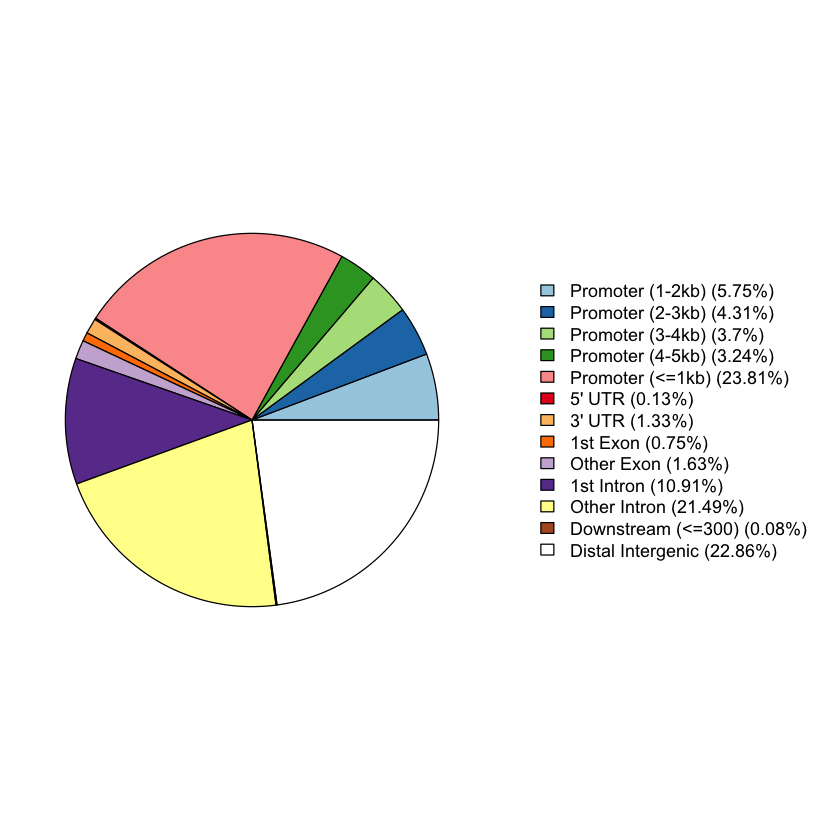

In [19]:
# make df for conversion
anno_peaks_pf <- lapply(cell_lines
                    ,function(cell_line){
                        my_anno_peaks <- anno_peaks_pf[[cell_line]]
                        #print(str(my_anno_peaks))
                        my_counts_pf <- counts_pf[[cell_line]]
                        
                        df <- as.data.frame(str_split_fixed(rownames(my_counts_pf)
                                              , "_"
                                              , 3)
                                            )
                        #print(str(df))
                        colnames(df) <- c("chr"
                                         ,"start"
                                         ,"end")
                        df$chr <- paste0("chr"
                                        ,df$chr)

                        gr = makeGRangesFromDataFrame(cbind(df
                                                           ,my_counts_pf)
                                                      ,keep.extra.columns=T
                                                     )
                        peakAnno = annotatePeak(gr
                                                ,tssRegion=c(-5000, 5000)
                                                ,TxDb=TxDb.Hsapiens.UCSC.hg38.knownGene
                                                ,annoDb="org.Hs.eg.db"
                                               )
                        print(plotAnnoPie(peakAnno))
                        #print(str(peakAnno))
                        
                        #print(str(my_anno_peaks))
                        my_anno_peaks$annoPackage <- "ChIPseeker.v1.8.6"
                        my_anno_peaks$TxDb <- "TxDb.Hsapiens.UCSC.hg38.knownGene"
                        my_anno_peaks$tssRegion <- toString(peakAnno@tssRegion)
                        my_anno_peaks$level <- peakAnno@level
                        #print(str(my_anno_peaks))
                        #print(str(peakAnno@detailGenomicAnnotation))
                        my_anno_peaks <- cbind(my_anno_peaks
                                              ,peakAnno@detailGenomicAnnotation)
                        my_anno_peaks <- cbind(my_anno_peaks
                                              ,peakAnno@anno@elementMetadata@listData[c("annotation"
                                                                                        ,"geneChr"
                                                                                        ,"geneStart"
                                                                                        ,"geneEnd"
                                                                                        ,"geneLength"
                                                                                        ,"geneStrand"
                                                                                        ,"geneId"
                                                                                        ,"transcriptId"
                                                                                        ,"distanceToTSS"
                                                                                        ,"ENSEMBL"
                                                                                        ,"SYMBOL"
                                                                                        ,"GENENAME")])
                        
                        my_anno_peaks
                    })
names(anno_peaks_pf) <- cell_lines
print(str(anno_peaks_pf))

In [20]:
for (cell_line in cell_lines){
    print(cell_line)
    
    my_counts <- counts_pf[[cell_line]]
    my_anno_peaks <- anno_peaks_pf[[cell_line]]
    
    idx_bad <- is.na(my_anno_peaks$ENSEMBL)
    print("number NA genes:")
    print(sum(idx_bad))
    
    my_counts <- my_counts[!idx_bad,]
    my_anno_peaks <- my_anno_peaks[!idx_bad,]
    
    #print(unique(my_anno_peaks$annotation))
    
    counts_pf[[cell_line]] <- my_counts
    anno_peaks_pf[[cell_line]] <- my_anno_peaks
}

[1] "Ly1"
[1] "number NA genes:"
[1] 10896
[1] "Ly8"
[1] "number NA genes:"
[1] 15331


In [21]:
# keep only promoter peaks

for (cell_line in cell_lines){
    print(cell_line)
    
    my_counts <- counts_pf[[cell_line]]
    my_anno_peaks <- anno_peaks_pf[[cell_line]]
    
    idx_bad <- !grepl("Promoter",my_anno_peaks$annotation)
    print("number non-promoter genes:")
    print(sum(idx_bad))
    
    my_counts <- my_counts[!idx_bad,]
    my_anno_peaks <- my_anno_peaks[!idx_bad,]
    
    print(dim(my_counts))
    #print(unique(my_anno_peaks$annotation))
    
    counts_pf[[cell_line]] <- my_counts
    anno_peaks_pf[[cell_line]] <- my_anno_peaks
}

[1] "Ly1"
[1] "number non-promoter genes:"
[1] 54676
[1] 51339     8
[1] "Ly8"
[1] "number non-promoter genes:"
[1] 77013
[1] 56996     7


# Normalization

In [22]:
# add column "contrast" with values het+KO or cas9 THIS WILL BE NEEDED FOR THE DIFFERENTIAL PEAK CALLING
anno_samples <- lapply(cell_lines
                      ,function(cell_line){
                          
                          my_anno_samples <- anno_samples[[cell_line]]
                          
                          my_anno_samples$contrast <- sapply(my_anno_samples$genotype
                                                             ,function(i) {
                                                                 ifelse(i == "cas9", "cas9", "het+KO")
                                                                 })
                          
                          my_anno_samples
                      })
names(anno_samples) <- cell_lines
print(str(anno_samples))

List of 2
 $ Ly1:'data.frame':	8 obs. of  29 variables:
  ..$ ID_renamed                   : chr [1:8] "Ly1_KO_E8_1" "Ly1_KO_G1_1" "Ly1_KO_H3_1" "Ly1_cas9_N1_1" ...
  ..$ ID_original                  : chr [1:8] "read1_CGTACTAG_CTCTCTAT_Ly1_KO_E8.fastq" "read1_GGACTCCT_CTCTCTAT_Ly1_KO_G1.fastq" "read1_TAGGCATG_CTCTCTAT_Ly1_KO_H3.fastq" "read1_TAAGGCGA_GCGTAAGA_Ly1_cas9_N1.fastq" ...
  ..$ read                         : int [1:8] 1 1 1 1 1 1 1 1
  ..$ index1                       : chr [1:8] "CGTACTAG" "GGACTCCT" "TAGGCATG" "TAAGGCGA" ...
  ..$ index2                       : chr [1:8] "CTCTCTAT" "CTCTCTAT" "CTCTCTAT" "GCGTAAGA" ...
  ..$ cell_line                    : chr [1:8] "Ly1" "Ly1" "Ly1" "Ly1" ...
  ..$ genotype                     : chr [1:8] "KO" "KO" "KO" "cas9" ...
  ..$ clone                        : chr [1:8] "E8" "G1" "H3" "N1" ...
  ..$ seq_run                      : int [1:8] 2 2 2 2 2 2 2 2
  ..$ sample_prep                  : int [1:8] 3 3 3 3 2 3 3 3
  ..$ sample    

In [23]:
# normalize counts
dds <- lapply(cell_lines
                     ,function(cell_line){
                         
                         my_counts <- counts_pf[[cell_line]]
                         my_anno_samples <- anno_samples[[cell_line]]
                         
                         dds = DESeqDataSetFromMatrix(countData = my_counts
                                                      , colData = my_anno_samples
                                                      , design = ~ contrast
                                                     )
                         dds = DESeq(dds)
                         dds
                     })
names(dds) <- cell_lines
print(str(dds))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
 

List of 2
 $ Ly1:Formal class 'DESeqDataSet' [package "DESeq2"] with 8 slots
  .. ..@ design            :Class 'formula'  language ~contrast
  .. .. .. ..- attr(*, ".Environment")=<environment: 0x7fbd5f6c0910> 
  .. ..@ dispersionFunction:function (q)  
  .. .. ..- attr(*, "coefficients")= Named num [1:2] 0.0181 2.3063
  .. .. .. ..- attr(*, "names")= chr [1:2] "asymptDisp" "extraPois"
  .. .. ..- attr(*, "fitType")= chr "parametric"
  .. .. ..- attr(*, "varLogDispEsts")= num 0.678
  .. .. ..- attr(*, "dispPriorVar")= num 0.283
  .. ..@ rowRanges         :Formal class 'CompressedGRangesList' [package "GenomicRanges"] with 5 slots
  .. .. .. ..@ unlistData     :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  .. .. .. .. .. ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. .. .. .. .. .. ..@ values         : Factor w/ 0 levels: 
  .. .. .. .. .. .. .. ..@ lengths        : int(0) 
  .. .. .. .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .

In [24]:
# extract normalized counts
counts_norm <- lapply(cell_lines
                     ,function(cell_line){
                         
                         my_dds = dds[[cell_line]]
                         counts_pf_norm = data.frame(counts(my_dds, normalized=TRUE))
                     })
names(counts_norm) <- cell_lines
print(str(counts_norm))

List of 2
 $ Ly1:'data.frame':	51339 obs. of  8 variables:
  ..$ Ly1_KO_E8  : num [1:51339] 18.6 1889.7 24 71 17.5 ...
  ..$ Ly1_KO_G1  : num [1:51339] 6.93 1545.03 27.7 94.88 10.39 ...
  ..$ Ly1_KO_H3  : num [1:51339] 12.8 2269.5 13.8 82.6 23.9 ...
  ..$ Ly1_cas9_N1: num [1:51339] 32.9 1576.3 11.5 67.5 23 ...
  ..$ Ly1_cas9_N7: num [1:51339] 61.1 1958.6 18.6 67.3 42.4 ...
  ..$ Ly1_cas9_N9: num [1:51339] 12 1144.5 19.4 100.4 32.5 ...
  ..$ Ly1_het_F10: num [1:51339] 32.3 2373.8 16.9 90.7 10.8 ...
  ..$ Ly1_het_F9 : num [1:51339] 6.62 1592.57 30.63 75.32 38.08 ...
 $ Ly8:'data.frame':	56996 obs. of  7 variables:
  ..$ Ly8_KO_G6   : num [1:56996] 4.65 3150.03 60.43 7.75 193.68 ...
  ..$ Ly8_cas9_N11: num [1:56996] 16.8 4260.6 50.5 16.8 182.3 ...
  ..$ Ly8_cas9_N3 : num [1:56996] 6.2 3604.9 44.4 18.6 140.6 ...
  ..$ Ly8_cas9_N6 : num [1:56996] 8.23 2085.77 49.39 23.05 149.81 ...
  ..$ Ly8_het_A9  : num [1:56996] 0 2574.7 56.1 12 176.5 ...
  ..$ Ly8_het_G10 : num [1:56996] 4.14 3334.74 47

## Statistics after normalization

In [25]:
# add total norm counts to annotation
for(cell_line in cell_lines){
    anno_samples[[cell_line]]$total_counts_norm <- colSums(counts_norm[[cell_line]])
}
print(str(anno_samples))

List of 2
 $ Ly1:'data.frame':	8 obs. of  29 variables:
  ..$ ID_renamed                   : chr [1:8] "Ly1_KO_E8_1" "Ly1_KO_G1_1" "Ly1_KO_H3_1" "Ly1_cas9_N1_1" ...
  ..$ ID_original                  : chr [1:8] "read1_CGTACTAG_CTCTCTAT_Ly1_KO_E8.fastq" "read1_GGACTCCT_CTCTCTAT_Ly1_KO_G1.fastq" "read1_TAGGCATG_CTCTCTAT_Ly1_KO_H3.fastq" "read1_TAAGGCGA_GCGTAAGA_Ly1_cas9_N1.fastq" ...
  ..$ read                         : int [1:8] 1 1 1 1 1 1 1 1
  ..$ index1                       : chr [1:8] "CGTACTAG" "GGACTCCT" "TAGGCATG" "TAAGGCGA" ...
  ..$ index2                       : chr [1:8] "CTCTCTAT" "CTCTCTAT" "CTCTCTAT" "GCGTAAGA" ...
  ..$ cell_line                    : chr [1:8] "Ly1" "Ly1" "Ly1" "Ly1" ...
  ..$ genotype                     : chr [1:8] "KO" "KO" "KO" "cas9" ...
  ..$ clone                        : chr [1:8] "E8" "G1" "H3" "N1" ...
  ..$ seq_run                      : int [1:8] 2 2 2 2 2 2 2 2
  ..$ sample_prep                  : int [1:8] 3 3 3 3 2 3 3 3
  ..$ sample    

[1] "Ly1"
[1] "Ly8"


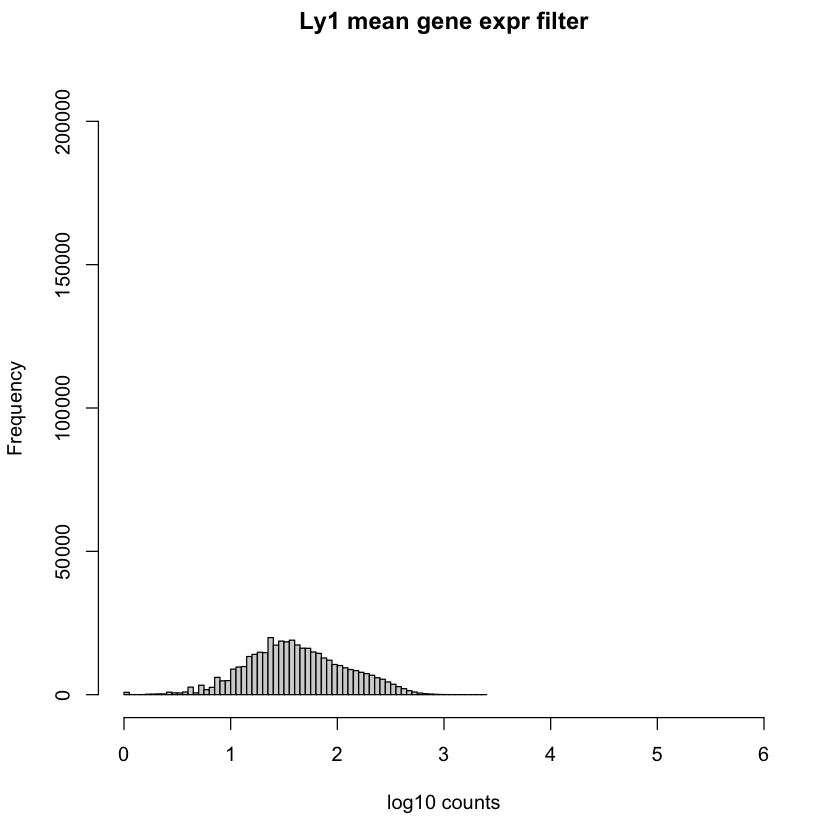

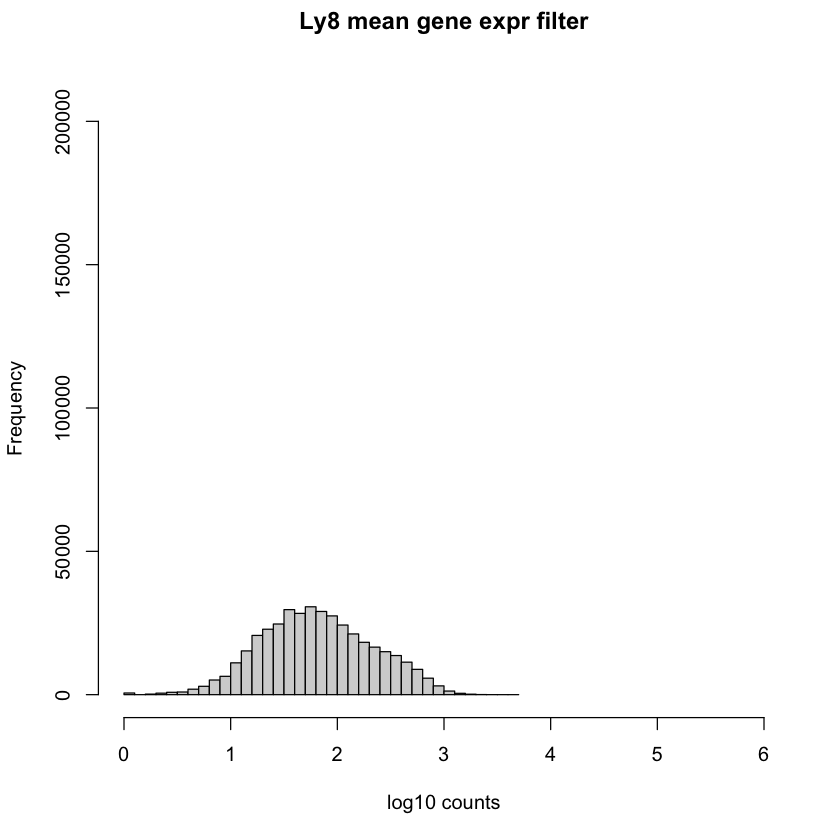

In [26]:
# make histogram of counts in all samples
for(cell_line in cell_lines){
    print(cell_line)
    
    # subsample counts
    my_counts <- counts_norm[[cell_line]]
    
    hist(log10(unlist(my_counts+1))
        ,breaks = 50
         ,main = paste(cell_line
                       ,"mean gene expr filter\n\n")
         ,ylab = "Frequency"
         ,xlab = "log10 counts"
         ,xlim = c(0,6)
         ,ylim = c(0,200000)
        )
}




[1] "Ly1"
   variable      value
1 Ly1_KO_E8   18.56895
2 Ly1_KO_E8 1889.66335
3 Ly1_KO_E8   24.03040
4 Ly1_KO_E8   70.99891
5 Ly1_KO_E8   17.47666
6 Ly1_KO_E8   54.61455
[1] "Ly8"
   variable       value
1 Ly8_KO_G6    4.648343
2 Ly8_KO_G6 3150.026823
3 Ly8_KO_G6   60.428454
4 Ly8_KO_G6    7.747238
5 Ly8_KO_G6  193.680941
6 Ly8_KO_G6   61.977901


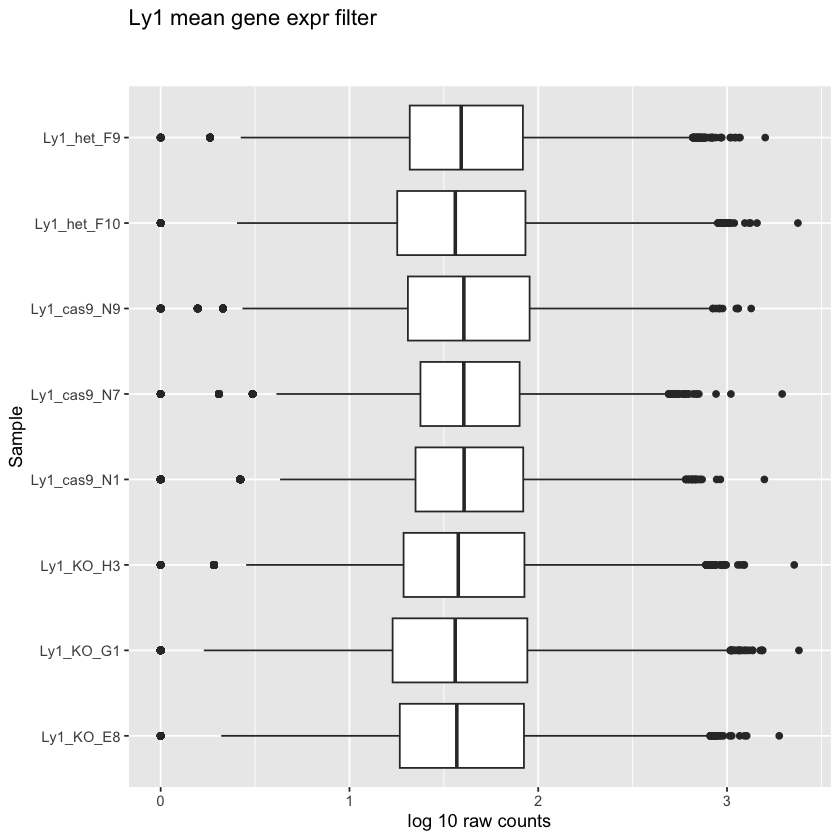

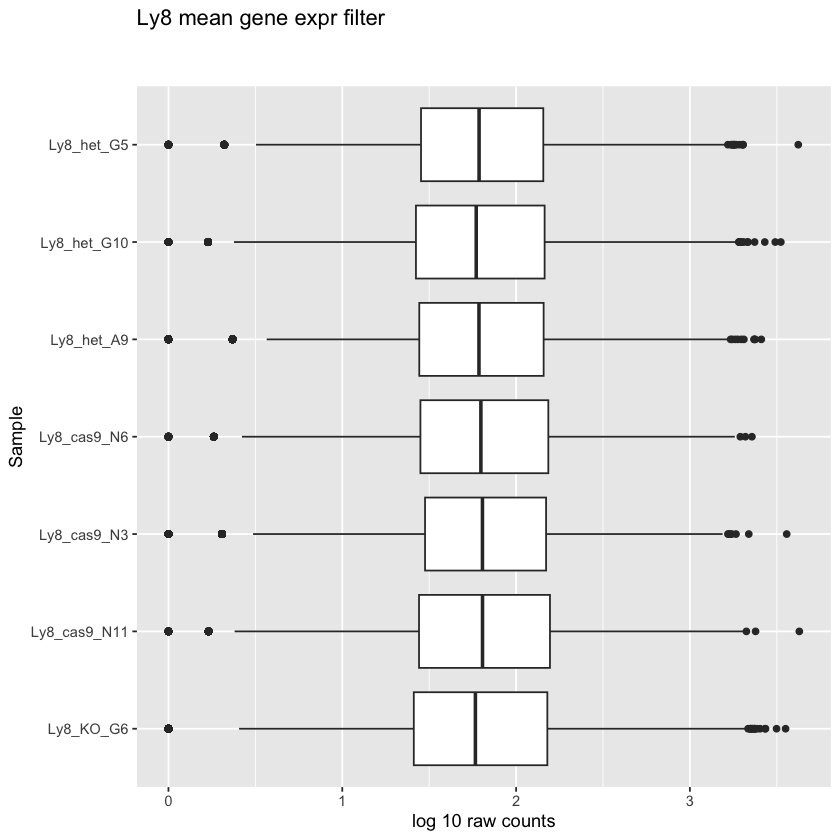

In [28]:
# bar plot of expression per sample
for(cell_line in cell_lines){
    print(cell_line)
    
    # subset counts
    my_counts <- counts_norm[[cell_line]]
    
    # prepare df for plotting
    lf = melt(my_counts, id.vars=c())
    print(head(lf))

    # plot
    p <- ggplot(data=lf
           ,aes(x=variable
                ,y=log10(value+1)
               )
          ) + 
    geom_boxplot(aes(group=variable)) + 
    xlab("Sample") + 
    ylab("log 10 raw counts") + 
    ggtitle(paste(cell_line
                       ,"mean gene expr filter\n\n")) +
      coord_flip()
    print(p)
}

# Differentially open peaks

In [29]:
threshold_padj <- 0.1

In [30]:
threshold_lfc <- 1

In [31]:
difPeaks_result_on_all_peaks <- lapply(cell_lines
                                       ,function(cell_line){
                                           my_dds <- dds[[cell_line]]
                                           my_anno_samples <- anno_samples[[cell_line]]
                                           contrast <- unique(my_anno_samples$contrast)
                                           
                                           res = results(my_dds
                                                         , lfcThreshold=1
                                                         , contrast=c("contrast"
                                                                      ,contrast[1] # mut: het + KO
                                                                      ,contrast[2] # wt: cas9
                                                                     )
                                                        )
                                           print(mcols(res, use.names=T))
                                           print(summary(res))
                                           res
                                       }
                                      )
names(difPeaks_result_on_all_peaks) <- cell_lines
print(str(difPeaks_result_on_all_peaks))

DataFrame with 6 rows and 2 columns
                       type            description
                <character>            <character>
baseMean       intermediate mean of normalized c..
log2FoldChange      results log2 fold change (ML..
lfcSE               results standard error: cont..
stat                results Wald statistic: cont..
pvalue              results Wald test p-value: c..
padj                results   BH adjusted p-values

out of 51339 with nonzero total read count
adjusted p-value < 0.1
LFC > 1.00 (up)    : 68, 0.13%
LFC < -1.00 (down) : 187, 0.36%
outliers [1]       : 4, 0.0078%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL
DataFrame with 6 rows and 2 columns
                       type            description
                <character>            <character>
baseMean       intermediate mean of normalized c..
log2FoldChange      results log2 fold change (ML..
lfcSE    

In [32]:
for(cell_line in cell_lines){
    my_do <- difPeaks_result_on_all_peaks[[cell_line]]
    my_anno_peaks <- anno_peaks_pf[[cell_line]]
    
    my_anno_peaks <- cbind(my_anno_peaks
                          ,as.data.frame(my_do@listData))
    
      my_anno_peaks$threshold_padj <- threshold_padj
      my_anno_peaks$threshold_lfc <- threshold_lfc
      my_anno_peaks$is_diff <- (my_anno_peaks$padj < my_anno_peaks$threshold_padj) & (
          abs(my_anno_peaks$log2FoldChange) > my_anno_peaks$threshold_lfc
      )
      my_anno_peaks$is_up_in_mut <- (my_anno_peaks$is_diff) & (my_anno_peaks$log2FoldChange > 0)
      my_anno_peaks$is_down_in_mut <- (my_anno_peaks$is_diff) & (my_anno_peaks$log2FoldChange < 0)
    
    anno_peaks[[cell_line]] <- my_anno_peaks
}

print(str(anno_peaks))

List of 2
 $ Ly1:'data.frame':	51339 obs. of  45 variables:
  ..$ peakID              : chr [1:51339] "1_181400_181555" "1_629896_629990" "1_804858_805040" "1_827273_827761" ...
  ..$ Chr                 : chr [1:51339] "1" "1" "1" "1" ...
  ..$ Start               : int [1:51339] 181400 629896 804858 827273 865730 869766 915579 919766 920550 921144 ...
  ..$ End                 : int [1:51339] 181555 629990 805040 827761 865924 870035 915747 919853 920834 921348 ...
  ..$ mean_count          : num [1:51339] 21.2 1844.8 23 90.5 27.8 ...
  ..$ threshold_mean_count: int [1:51339] 20 20 20 20 20 20 20 20 20 20 ...
  ..$ filter_mean_count   : logi [1:51339] TRUE TRUE TRUE TRUE TRUE TRUE ...
  ..$ threshold_count     : num [1:51339] 20 20 20 20 20 20 20 20 20 20 ...
  ..$ filter_count        : logi [1:51339] TRUE TRUE TRUE TRUE TRUE TRUE ...
  ..$ annoPackage         : chr [1:51339] "ChIPseeker.v1.8.6" "ChIPseeker.v1.8.6" "ChIPseeker.v1.8.6" "ChIPseeker.v1.8.6" ...
  ..$ TxDb               

In [33]:
for(cell_line in cell_lines){
    print(cell_line)
    
    my_do <- anno_peaks[[cell_line]]
    
    for(gene in c("FAS"
             ,"RUNX3"
             ,"ETS1")){
    
    idx_gene <- my_do$SYMBOL %in% gene
        
        print(my_do[idx_gene,c("SYMBOL"
                               ,"log2FoldChange"
                               ,"pvalue"
                              ,"padj")])
}
}

[1] "Ly1"
                     SYMBOL log2FoldChange pvalue padj
10_88987113_88987194    FAS      0.1322622      1    1
10_88990451_88990877    FAS     -0.4661617      1    1
10_88991303_88991478    FAS      0.2201192      1    1
10_88991699_88992075    FAS     -0.6243361      1    1
                    SYMBOL log2FoldChange     pvalue padj
1_24924187_24924334  RUNX3    -2.28374513 0.01474019    1
1_24925271_24925361  RUNX3    -2.25177511 0.03131769    1
1_24929545_24929917  RUNX3    -0.47519338 1.00000000    1
1_24930223_24930669  RUNX3     0.02477048 1.00000000    1
1_24932304_24932499  RUNX3     0.10648241 1.00000000    1
1_24934451_24934598  RUNX3    -1.17392133 0.79422054    1
1_24963581_24963762  RUNX3     0.33513713 1.00000000    1
                       SYMBOL log2FoldChange pvalue padj
11_128503402_128503616   ETS1     -0.9192050      1    1
11_128503826_128503914   ETS1      0.2798452      1    1
11_128507440_128507626   ETS1     -0.5801290      1    1
11_128508098_128508191 

# Export

In [34]:
# export normalized counts
for(cell_line in cell_lines){
    # subset counts
    my_counts <- counts_norm[[cell_line]]
    
    write.table(my_counts
               ,file = paste0("counts_norm_"
                             ,cell_line
                             ,".txt"
                             )
               ,sep = "\t"
               ,row.names = TRUE
               ,col.names= TRUE)
}

In [35]:
# export anno_peaks_pf
lapply(cell_lines
      ,function(cell_line){
          my_anno_peaks <- anno_peaks[[cell_line]]
          write.table(my_anno_peaks
                     ,file = paste0("anno_peaks_"
                                    ,cell_line 
                                    ,".txt"
                                   )
                      ,sep = "\t" 
                      ,row.names = TRUE 
                      ,col.names= TRUE
                     )
      })

[[1]]
NULL

[[2]]
NULL

In [36]:
# export anno_samples
lapply(cell_lines
      ,function(cell_line){
          my_anno_samples <- anno_samples[[cell_line]]
          write.table(my_anno_samples
                     ,file = paste0("anno_samples_"
                                    ,cell_line 
                                    ,".txt"
                                   )
                      ,sep = "\t" 
                      ,row.names = TRUE 
                      ,col.names= TRUE
                     )
      })

[[1]]
NULL

[[2]]
NULL

In [37]:
# export differential peaks
diffPeaks <- rbind(cbind(data.frame(cell_line = rep("OCI-Ly1"
                                                   ,nrow(anno_peaks[["Ly1"]])))
                         ,anno_peaks[["Ly1"]])
                  ,cbind(data.frame(cell_line = rep("OCI-Ly8"
                                                   ,nrow(anno_peaks[["Ly8"]])))
                         ,anno_peaks[["Ly8"]]))
print(str(diffPeaks))

# export data
write.table(diffPeaks
         ,file = "TableS1_diffPeaks_onPromoters.txt"
         ,sep = "\t"
           ,row.names = FALSE)

'data.frame':	108335 obs. of  46 variables:
 $ cell_line           : chr  "OCI-Ly1" "OCI-Ly1" "OCI-Ly1" "OCI-Ly1" ...
 $ peakID              : chr  "1_181400_181555" "1_629896_629990" "1_804858_805040" "1_827273_827761" ...
 $ Chr                 : chr  "1" "1" "1" "1" ...
 $ Start               : int  181400 629896 804858 827273 865730 869766 915579 919766 920550 921144 ...
 $ End                 : int  181555 629990 805040 827761 865924 870035 915747 919853 920834 921348 ...
 $ mean_count          : num  21.2 1844.8 23 90.5 27.8 ...
 $ threshold_mean_count: int  20 20 20 20 20 20 20 20 20 20 ...
 $ filter_mean_count   : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ threshold_count     : num  20 20 20 20 20 20 20 20 20 20 ...
 $ filter_count        : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ annoPackage         : chr  "ChIPseeker.v1.8.6" "ChIPseeker.v1.8.6" "ChIPseeker.v1.8.6" "ChIPseeker.v1.8.6" ...
 $ TxDb                : chr  "TxDb.Hsapiens.UCSC.hg38.knownGene" "TxDb.Hsapiens.UCSC.h